In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as tf

from torch.utils.data import Dataset, DataLoader, ConcatDataset

IMAGE_SIZE = 112
BATCH_SIZE = 64

In [2]:
# Set random seed for reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4080 Laptop GPU


In [3]:
# Dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            root (str): Path to the dataset directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.hf_path = os.path.join(self.root, "HF")
        self.lf_path = os.path.join(self.root, "LF")
        self.hf_image_names = sorted(os.listdir(self.hf_path))
        self.lf_image_names = sorted(os.listdir(self.lf_path))
        self.transform = transform

        # Set HF and LF pairs
        image_pair_names = list(zip(self.hf_image_names, self.lf_image_names))
        
        # Check if the pairs match
        for hf_image_name, lf_image_name in image_pair_names:
            # Check if HF and LF frequencies match
            hf_freq = hf_image_name.split("_")[2]
            lf_freq = lf_image_name.split("_")[2]
            if hf_freq != "HF" or lf_freq != "LF":
                raise ValueError("HF and LF frequencies image were placed in the wrong directories.")
            # Check if HF and LF frames match
            # Get frame numbers, type, and ID of HF image
            hf_frame_1, hf_frame_2 = hf_image_name.split("_")[0], hf_image_name.split("_")[1]
            hf_type = hf_image_name.split("_")[3]
            hf_id = hf_image_name.split("_")[4].split(".")[0]
            # Get frame numbers, type, and ID of LF image
            lf_frame_1, lf_frame_2 = lf_image_name.split("_")[0], lf_image_name.split("_")[1]
            lf_type = lf_image_name.split("_")[3]
            lf_id = lf_image_name.split("_")[4].split(".")[0]

            if hf_frame_1 != lf_frame_2 or hf_frame_2 != lf_frame_1 or hf_type != lf_type or hf_id != lf_id:
                raise ValueError("HF and LF frames do not match.")
        
        # Set image pair paths
        hf_image_paths = [os.path.join(self.hf_path, hf_image_name) for hf_image_name in self.hf_image_names]
        lf_image_paths = [os.path.join(self.lf_path, lf_image_name) for lf_image_name in self.lf_image_names]
        self.image_pair_paths = list(zip(hf_image_paths, lf_image_paths))
        
    def __len__(self):
        return len(self.image_pair_paths)
        
    def __getitem__(self, idx):
        # Load HF and LF images
        hf_image_path, lf_image_path = self.image_pair_paths[idx]
        hf_image = cv2.imread(hf_image_path, cv2.IMREAD_GRAYSCALE)
        lf_image = cv2.imread(lf_image_path, cv2.IMREAD_GRAYSCALE)
        
        # To tensor and unsqueeze
        hf_image = torch.tensor(hf_image, dtype=torch.float32).unsqueeze(0) ## [H, W] -> [1, H, W]
        lf_image = torch.tensor(lf_image, dtype=torch.float32).unsqueeze(0) ## [H, W] -> [1, H, W]
        
        # Apply augmentations
        if self.transform:
            hf_image, lf_image = self.transform(hf_image, lf_image)
        
        # Get label
        hf_image_name = os.path.basename(hf_image_path)
        type = hf_image_name.split("_")[3]
        if type == "needle":
            label = torch.tensor([1], dtype=torch.float32)
        else:
            label = torch.tensor([0], dtype=torch.float32)
        
        return hf_image, lf_image, label

In [4]:
# Data Augmentation
class Augmentation(nn.Module):
    def __init__(self, horizontal_flip=True, p=0.5):
        self.horizontal_flip = horizontal_flip
        self.p = p
        
    def __call__(self, hf_image, lf_image):
        # Resize images
        hf_image = tf.functional.resize(hf_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=tf.InterpolationMode.BILINEAR, antialias=True)
        lf_image = tf.functional.resize(lf_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=tf.InterpolationMode.BILINEAR, antialias=True)
        
        # Random horizontal flip
        if random.random() < self.p:
            hf_image = tf.functional.hflip(hf_image)
            lf_image = tf.functional.hflip(lf_image)
        
        # Normalize images
        hf_image = hf_image / 255.0
        lf_image = lf_image / 255.0
        
        # Remove leading dimension
        hf_image = hf_image.squeeze(0) ## [1, H, W] -> [H, W]
        lf_image = lf_image.squeeze(0) ## [1, H, W] -> [H, W]
        
        return hf_image, lf_image

In [5]:
train_transform = Augmentation(horizontal_flip=True)
valid_transform = Augmentation(horizontal_flip=True)

dataset_1 = CustomDataset(root="data/20240326_1347_BLOCK150_STEP15", transform=train_transform)
dataset_2 = CustomDataset(root="data/20240326_1437_BLOCK150_STEP15", transform=train_transform)
dataset_3 = CustomDataset(root="data/20240326_1523_BLOCK150_STEP15", transform=train_transform)
dataset_4 = CustomDataset(root="data/20240326_1457_BLOCK150_STEP15", transform=valid_transform)


train_dataset = ConcatDataset([dataset_1, dataset_2, dataset_3])
valid_dataset = dataset_4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

Train dataset size: 15095
Valid dataset size: 3874


In [6]:
# Count number of needle and fascia samples in the train dataset
needle_count = 0
fascia_count = 0
for hf_images, lf_images, labels in train_loader:
    needle_count += labels.sum().item()
    fascia_count += (1 - labels).sum().item()
needle_count = int(needle_count)
fascia_count = int(fascia_count)
print(f"Needle count: {needle_count}")
print(f"Fascia count: {fascia_count}")

Needle count: 7100
Fascia count: 7940


In [7]:
def plot_pair_image(hf_image, lf_image, label):
    fig, axes = plt.subplots(1, 2, figsize=(3, 2))
    axes[0].imshow(hf_image, cmap="gray")
    axes[0].set_title("HF Image")
    axes[0].axis("off")
    axes[1].imshow(lf_image, cmap="gray")
    axes[1].set_title("LF Image")
    axes[1].axis("off")
    plt.suptitle(f"Label: {label}", y=0.2)
    plt.show()

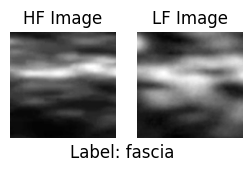

fascia tensor([0.])
torch.Size([112, 112]) torch.Size([112, 112])


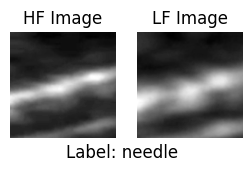

needle tensor([1.])
torch.Size([112, 112]) torch.Size([112, 112])


In [8]:
# Show a random pair of HF and LF images
show_fascia = False
show_needle = False
for idx, (hf_image, lf_image, label) in enumerate(dataset_3):
    if label[0] == 0 and not show_fascia:
        plot_pair_image(hf_image, lf_image, "fascia")
        print("fascia", label)
        show_fascia = True
        print(hf_image.shape, lf_image.shape)
    if label[0] == 1 and not show_needle:
        plot_pair_image(hf_image, lf_image, "needle")
        print("needle", label)
        show_needle = True
        print(hf_image.shape, lf_image.shape)
        
    if show_fascia and show_needle:
        break

In [9]:
# ConvNeXt
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.


import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], 1)
        self.sigmoid = nn.Sigmoid()

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)
        

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        x = self.sigmoid(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

c:\Users\sonav\miniconda3\envs\dlmi_hw1_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# class balanced_cross_entropy_loss(nn.Module):
#     def __init__(self, alpha=0.8):
#         super().__init__()
#         self.alpha = alpha
    
#     def forward(self, inputs, targets):
#         alpha_t = [self.alpha if target == 1 else 1-self.alpha for target in targets]
#         alpha_t = torch.tensor(alpha_t).to(device)
#         BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
#         balanced_BCE_loss = alpha_t * BCE_loss

#         return balanced_BCE_loss.mean()


# class focal_loss(nn.Module):
#     def __init__(self, alpha=0.25, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         alpha_t = [self.alpha if target == 1 else 1-self.alpha for target in targets]
#         alpha_t = torch.tensor(alpha_t).to(device)
#         BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         return F_loss.mean()

In [10]:
def validation(model, device, data_loader, data_loader_type, criterion, mode="dual", num_channel=2):
    model.eval()
    model.to(device)
    
    accumulated_loss = 0

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    with torch.no_grad():
        for batch_idx, (hf_images, lf_images, labels) in enumerate(data_loader):
            # Set data to device and add channel dimension
            hf_images, lf_images, labels = hf_images.to(device), lf_images.to(device), labels.to(device)
            hf_images, lf_images = hf_images.unsqueeze(1), lf_images.unsqueeze(1)
            
            # Inputs mode
            if mode == "dual" and num_channel == 2:
                inputs = torch.cat((hf_images, lf_images), dim=1)
            elif mode == "HF" and num_channel == 2:
                inputs = torch.cat((hf_images, hf_images), dim=1)
            elif mode == "LF" and num_channel == 2:
                inputs = torch.cat((lf_images, lf_images), dim=1)
            elif mode == "HF" and num_channel == 1:
                inputs = hf_images
            elif mode == "LF" and num_channel == 1:
                inputs = lf_images
            elif mode == "freq_independent" and num_channel == 2:
                inputs = [hf_images[idx] if random.random() > 0.5 else lf_images[idx] for idx in range(labels.shape[0])]
                inputs = torch.stack(inputs)
                inputs = torch.cat((inputs, inputs), dim=1)
            elif mode == "freq_independent" and num_channel == 1:
                inputs = [hf_images[idx] if random.random() > 0.5 else lf_images[idx] for idx in range(labels.shape[0])]
                inputs = torch.stack(inputs)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            predictions = torch.round(outputs)
            accumulated_loss += criterion(outputs, labels)

            # Calculate metrics
            true_pos += ((predictions == 1) & (labels == 1)).sum().item()
            true_neg += ((predictions == 0) & (labels == 0)).sum().item()
            false_pos += ((predictions == 1) & (labels == 0)).sum().item()
            false_neg += ((predictions == 0) & (labels == 1)).sum().item()
    
    mean_loss = accumulated_loss / len(data_loader)

    # Calculate performance metrics
    epsilon = 1e-6 ## to avoid division by zero
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg + epsilon)
    recall = true_pos / (true_pos + false_neg + epsilon)
    precision = true_pos / (true_pos + false_pos + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    specificity = true_neg / (true_neg + false_pos + epsilon)

    # Show performance metrics
    print("-" * 42)
    print(f"--- Model Performance on {data_loader_type} Dataset ---")
    print(f"Mean Batch Loss: {mean_loss}")
    print(f"True Pos: {true_pos}, True Neg: {true_neg}, False Pos: {false_pos}, False Neg: {false_neg}")
    print(f"Accuracy: {accuracy:.5f}, Recall: {recall:.5f}, Precision: {precision:.5f}, F1 Score: {f1_score:.5f}, Specificity: {specificity:.5f}")

    return mean_loss, accuracy
    

In [11]:
def train(model, device, epochs, train_loader, valid_loader, optimizer, criterion, model_save_name, running_loss_steps=40, mode="dual", num_channel=2):
    # Set model to training mode
    model.train()
    model.to(device)
    running_loss = 0.0
    best_mean_loss = 10000
    best_accuracy = 0
    
    # Iterate over epochs
    for epoch in range(epochs):
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        loss = 0.0
        
        # Iterate over dataloader
        for step, (hf_images, lf_images, labels) in enumerate(train_loader):
            
            # Set data to device and add channel dimension
            hf_images, lf_images, labels = hf_images.to(device), lf_images.to(device), labels.to(device)
            hf_images, lf_images = hf_images.unsqueeze(1), lf_images.unsqueeze(1)

            # Inputs mode
            if mode == "dual" and num_channel == 2:
                inputs = torch.cat((hf_images, lf_images), dim=1)
            elif mode == "HF" and num_channel == 2:
                inputs = torch.cat((hf_images, hf_images), dim=1)
            elif mode == "LF" and num_channel == 2:
                inputs = torch.cat((lf_images, lf_images), dim=1)
            elif mode == "HF" and num_channel == 1:
                inputs = hf_images
            elif mode == "LF" and num_channel == 1:
                inputs = lf_images
            elif mode == "freq_independent" and num_channel == 2:
                inputs = [hf_images[idx] if random.random() > 0.5 else lf_images[idx] for idx in range(labels.shape[0])]
                inputs = torch.stack(inputs)
                inputs = torch.cat((inputs, inputs), dim=1)
            elif mode == "freq_independent" and num_channel == 1:
                inputs = [hf_images[idx] if random.random() > 0.5 else lf_images[idx] for idx in range(labels.shape[0])]
                inputs = torch.stack(inputs)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Calculate running loss and print loss
            running_loss += loss
            if step % running_loss_steps == running_loss_steps - 1:
                print("-" * 100)
                print(f"Epoch: {epoch+1}, Step: {step+1}, Loss: {running_loss/running_loss_steps:.5f}")
                running_loss = 0.0
                
                # test the model on training set and validation set
                _, _ = validation(model, device, train_loader, "Train", criterion, mode, num_channel)
                mean_loss, accuracy = validation(model, device, valid_loader, "Valid", criterion, mode, num_channel)
                
                if best_mean_loss > mean_loss:
                    best_mean_loss = mean_loss
                if best_accuracy < accuracy:
                    best_accuracy = accuracy
                    torch.save(model.state_dict(), f"{model_save_name}.pth")
                print(f"--- Best Mean Loss on Valid: {best_mean_loss:.5f}, Best Accuracy on Valid: {best_accuracy:.5f} ---\n")
                
                model.train()

20240326: dual freq, 2-channel

In [12]:
# 20240326: dual freq, 2-channel (trial 1)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4) 
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_DUAL_2_CHANNEL_v1", mode="dual", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.73464
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6862040758132935
True Pos: 23, True Neg: 7940, False Pos: 5, False Neg: 7072
Accuracy: 0.52945, Recall: 0.00324, Precision: 0.82143, F1 Score: 0.00646, Specificity: 0.99937
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6723601222038269
True Pos: 12, True Neg: 2317, False Pos: 4, False Neg: 1541
Accuracy: 0.60119, Recall: 0.00773, Precision: 0.75000, F1 Score: 0.01530, Specificity: 0.99828
--- Best Mean Loss on Valid: 0.67236, Best Accuracy on Valid: 0.60119 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.68510
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Lo

In [13]:
# 20240326: dual freq, 2-channel (trial 2)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_DUAL_2_CHANNEL_v2", mode="dual", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.77659
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6956674456596375
True Pos: 7067, True Neg: 87, False Pos: 7855, False Neg: 31
Accuracy: 0.47566, Recall: 0.99563, Precision: 0.47360, F1 Score: 0.64187, Specificity: 0.01095
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.7073189616203308
True Pos: 1553, True Neg: 0, False Pos: 2321, False Neg: 0
Accuracy: 0.40088, Recall: 1.00000, Precision: 0.40088, F1 Score: 0.57232, Specificity: 0.00000
--- Best Mean Loss on Valid: 0.70732, Best Accuracy on Valid: 0.40088 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.68959
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Lo

In [14]:
# 20240326: dual freq, 2-channel (trial 3)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_DUAL_2_CHANNEL_v3", mode="dual", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.75144
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6879886388778687
True Pos: 0, True Neg: 7950, False Pos: 0, False Neg: 7090
Accuracy: 0.52859, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6708285212516785
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67083, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69017
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

20240326: freq independent, 2-channel

In [15]:
# 20240326: freq independent, 2-channel (trial 1)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_2_CHANNEL_v1", mode="freq_independent", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.73970
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6929848194122314
True Pos: 0, True Neg: 7945, False Pos: 0, False Neg: 7095
Accuracy: 0.52826, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6741083264350891
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67411, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69280
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [16]:
# 20240326: freq independent, 2-channel (trial 2)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_2_CHANNEL_v2", mode="freq_independent", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.76457
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6902892589569092
True Pos: 0, True Neg: 7949, False Pos: 0, False Neg: 7091
Accuracy: 0.52852, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6844419240951538
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.68444, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.68870
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [17]:
# 20240326: freq independent, 2-channel (trial 3)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_2_CHANNEL_v3", mode="freq_independent", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.75069
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6967807412147522
True Pos: 0, True Neg: 7938, False Pos: 0, False Neg: 7102
Accuracy: 0.52779, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6719522476196289
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67195, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69836
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

20240326: HF only, 2-channel

In [18]:
# 20240326: HF only, 2-channel (trial 1)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_2_CHANNEL_v1", mode="HF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.76816
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.7105894684791565
True Pos: 7099, True Neg: 0, False Pos: 7941, False Neg: 0
Accuracy: 0.47201, Recall: 1.00000, Precision: 0.47201, F1 Score: 0.64131, Specificity: 0.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.7335684299468994
True Pos: 1553, True Neg: 0, False Pos: 2321, False Neg: 0
Accuracy: 0.40088, Recall: 1.00000, Precision: 0.40088, F1 Score: 0.57232, Specificity: 0.00000
--- Best Mean Loss on Valid: 0.73357, Best Accuracy on Valid: 0.40088 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69598
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [19]:
# 20240326: HF only, 2-channel (trial 2)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_2_CHANNEL_v2", mode="HF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.72821
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.688997745513916
True Pos: 0, True Neg: 7947, False Pos: 0, False Neg: 7093
Accuracy: 0.52839, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6769096851348877
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67691, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69616
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss:

In [20]:
# 20240326: HF only, 2-channel (trial 3)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_2_CHANNEL_v3", mode="HF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.78063
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.691764771938324
True Pos: 0, True Neg: 7942, False Pos: 0, False Neg: 7098
Accuracy: 0.52806, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.675922155380249
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67592, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69632
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 

20240326: LF only, 2-channel

In [21]:
# 20240326: LF only, 2-channel (trial 1)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_2_CHANNEL_v1", mode="LF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.75342
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6907386183738708
True Pos: 0, True Neg: 7942, False Pos: 0, False Neg: 7098
Accuracy: 0.52806, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6855171918869019
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.68552, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69387
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [22]:
# 20240326: LF only, 2-channel (trial 2)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_2_CHANNEL_v2", mode="LF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.77675
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6911177635192871
True Pos: 0, True Neg: 7939, False Pos: 0, False Neg: 7101
Accuracy: 0.52786, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6873466968536377
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.68735, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69885
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [23]:
# 20240326: LF only, 2-channel (trial 3)

model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_2_CHANNEL_v3", mode="LF", num_channel=2)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.76263
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.7117360830307007
True Pos: 0, True Neg: 7947, False Pos: 0, False Neg: 7093
Accuracy: 0.52839, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6734616160392761
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67346, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.70087
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

20240326: freq independent, 1-channel

In [24]:
# 20240326: freq independent, 1-channel (trial 1)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_1_CHANNEL_v1", mode="freq_independent", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.75642
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6920104026794434
True Pos: 0, True Neg: 7942, False Pos: 0, False Neg: 7098
Accuracy: 0.52806, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6749923229217529
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67499, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69013
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [25]:
# 20240326: freq independent, 1-channel (trial 2)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_1_CHANNEL_v2", mode="freq_independent", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.72578
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6934190392494202
True Pos: 0, True Neg: 7944, False Pos: 0, False Neg: 7096
Accuracy: 0.52819, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6703954339027405
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67040, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69874
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [26]:
# 20240326: freq independent, 1-channel (trial 3)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_FREQ_IND_1_CHANNEL_v3", mode="freq_independent", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.73647
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6900054216384888
True Pos: 0, True Neg: 7948, False Pos: 0, False Neg: 7092
Accuracy: 0.52846, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6740403771400452
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67404, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69361
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

20240326: HF only, 1-channel

In [27]:
# 20240326: HF only, 1-channel (trial 1)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_1_CHANNEL_v1", mode="HF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.74105
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.7184468507766724
True Pos: 0, True Neg: 7941, False Pos: 0, False Neg: 7099
Accuracy: 0.52799, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6737673878669739
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67377, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69629
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [28]:
# 20240326: HF only, 1-channel (trial 2)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_1_CHANNEL_v2", mode="HF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.76263
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.7060906291007996
True Pos: 0, True Neg: 7949, False Pos: 0, False Neg: 7091
Accuracy: 0.52852, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6711304783821106
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67113, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69215
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [29]:
# 20240326: HF only, 1-channel (trial 3)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_HF_1_CHANNEL_v3", mode="HF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.75979
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6889889240264893
True Pos: 0, True Neg: 7950, False Pos: 0, False Neg: 7090
Accuracy: 0.52859, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6764196157455444
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67642, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.70079
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

20240326: LF only, 1-channel

In [30]:
# 20240326: LF only, 1-channel (trial 1)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_1_CHANNEL_v1", mode="LF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.77826
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6905726790428162
True Pos: 0, True Neg: 7946, False Pos: 0, False Neg: 7094
Accuracy: 0.52832, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6846771836280823
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.68468, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69791
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss

In [31]:
# 20240326: LF only, 1-channel (trial 2)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_1_CHANNEL_v2", mode="LF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.79038
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.6945163607597351
True Pos: 7098, True Neg: 24, False Pos: 7918, False Neg: 0
Accuracy: 0.47354, Recall: 1.00000, Precision: 0.47270, F1 Score: 0.64195, Specificity: 0.00302
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6994404196739197
True Pos: 1553, True Neg: 0, False Pos: 2321, False Neg: 0
Accuracy: 0.40088, Recall: 1.00000, Precision: 0.40088, F1 Score: 0.57232, Specificity: 0.00000
--- Best Mean Loss on Valid: 0.69944, Best Accuracy on Valid: 0.40088 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69737
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Los

In [32]:
# 20240326: LF only, 1-channel (trial 3)

model_tiny = ConvNeXt(in_chans=1, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
optimizer = torch.optim.Adam(model_tiny.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train(model_tiny, device, 6, train_loader, valid_loader, optimizer, criterion, model_save_name="20240326_LF_1_CHANNEL_v3", mode="LF", num_channel=1)

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 40, Loss: 0.74146
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 0.69916832447052
True Pos: 0, True Neg: 7945, False Pos: 0, False Neg: 7095
Accuracy: 0.52826, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
------------------------------------------
--- Model Performance on Valid Dataset ---
Mean Batch Loss: 0.6706631779670715
True Pos: 0, True Neg: 2321, False Pos: 0, False Neg: 1553
Accuracy: 0.59912, Recall: 0.00000, Precision: 0.00000, F1 Score: 0.00000, Specificity: 1.00000
--- Best Mean Loss on Valid: 0.67066, Best Accuracy on Valid: 0.59912 ---

----------------------------------------------------------------------------------------------------
Epoch: 1, Step: 80, Loss: 0.69566
------------------------------------------
--- Model Performance on Train Dataset ---
Mean Batch Loss: 

Validation

In [ ]:
# 20240326: dual freq, 2-channel (trial 1)
# load model
model_tiny = ConvNeXt(in_chans=2, num_classes=2, depths=[3, 3, 27, 3], dims=[96, 192, 384, 768])
model_tiny.load_state_dict(torch.load("./20240326_DUAL_2_CHANNEL_v1.pth"))
criterion = nn.BCELoss()
validation(model_tiny, device, valid_loader, "Valid", criterion, mode="dual", num_channel=2)